In [1]:
# Import libraries
import pandas as pd
from pandas_datareader import data as pdr

import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import talib, re, ipyparams

from Agent import Agent

C:\Users\Elid-PC.DESKTOP-MG9DS93\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<IPython.core.display.Javascript object>

Using TensorFlow backend.


In [2]:
end_date = '2020-04-19'
start_date = '2017-04-20'

symbol = 'WBA'
Date = pd.DataFrame(pdr.DataReader(symbol,'yahoo', start_date, end_date))

alldata = pd.DataFrame({'Date': Date.index})
alldata[symbol] = pdr.DataReader(symbol, 'yahoo', start_date, end_date)['Adj Close'].values
# Stock symbol

# Load close prices of to NumPy array
close = alldata[symbol].values
len(close)

755

In [3]:
close

array([77.19835663, 77.78074646, 77.67904663, 77.91015625, 79.42620087,
       79.42620087, 79.39845276, 79.99933624, 79.92538452, 79.3245163 ,
       79.3060379 , 79.54637146, 79.39845276, 79.35223389, 79.48166656,
       79.14888763, 79.03794098, 78.80684662, 78.53875732, 78.46911621,
       75.88782501, 75.62784576, 74.84788513, 75.5256958 , 75.43284607,
       74.82003784, 74.97789001, 75.44213867, 74.43005371, 75.22858429,
       76.30567169, 77.15989685, 77.41988373, 75.62784576, 75.637146  ,
       75.64643097, 75.200737  , 75.9621048 , 75.95284271, 76.95561981,
       76.65850067, 72.83300781, 74.10507965, 72.70302582, 72.53588104,
       70.9109726 , 70.88312531, 71.98805237, 71.73734283, 71.57949829,
       72.768013  , 72.7122879 , 72.54515839, 73.0187149 , 72.16447449,
       71.93235779, 71.64450073, 71.76521301, 71.97877502, 72.43375397,
       73.26941681, 73.52011871, 73.04656219, 73.87294769, 74.09579468,
       73.26012421, 73.91007996, 74.33719635, 73.0558548 , 73.14

In [4]:
macd, macdsignal, macdhist = talib.MACD(close, fastperiod=5, slowperiod=20, signalperiod=9)
macdhist = macdhist[~np.isnan(macdhist)]
macd = macd[-len(macdhist):]
macdsignal = macdsignal[-len(macdhist):]


pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist': macdhist}).head()

,macd,macdsignal,macdhist
0,-1.562905,-1.392132,-0.170773
1,-1.637965,-1.441299,-0.196666
2,-1.441114,-1.441262,0.000148
3,-1.020179,-1.357045,0.336866
4,-0.530509,-1.191738,0.661229


In [5]:
def prepare_dataset(close):
    """
    Function prepare_dataset to generate input data and trading strategy from stock close prices
    """

    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

    # Cancel NaN values
    macdhist = macdhist[~np.isnan(macdhist)]
    macd = macd[-len(macdhist):]
    macdsignal = macdsignal[-len(macdhist):]

    # Scaling features to a range [0, 1]
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    macdhist_norm = min_max_scaler.fit_transform(np.expand_dims(macdhist, axis=1))

    # Implement strategy
    start_sell = 0.2
    stop_sell = 0.05
    start_buy = -0.2
    stop_buy = -0.05

    y = np.full(len(macdhist), np.nan)
    y[0] = 0

    for i in range(1, len(macdhist)):

        if y[i-1] == 0:
            if (macdhist_norm[i] >= start_sell):
                # Enter sell position
                y[i] = -1
            elif (macdhist_norm[i] <= start_buy):
                # Enter buy position
                y[i] = 1
            else:
                y[i] = 0
        elif y[i-1] == -1:
            if macdhist_norm[i] > stop_sell:
                # Stay in sell position
                y[i] = -1
            else:
                # Leave sell position
                y[i] = 0
        else:
            if macdhist_norm[i] < stop_buy:
                # Stay in buy position
                y[i] = 1
            else:
                # Leave buy position
                y[i] = 0

    # Plot strategy
    dates = np.arange(len(macdhist))
    plt.plot(dates, y,'g', label='Strategy Positions')
    plt.bar(dates, macdhist_norm[:, 0], width=1, color='blue', label='MACD histogram')
    plt.plot(dates, start_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, start_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.xlabel('Days')
    plt.xlim((0, len(y)))
    plt.legend()
    # plt.savefig('images/AAL_macd.png', bbox_inches='tight')
    plt.show()
    
    # Generate input data - technical indicators
    ind1 = talib.MIDPOINT(close)    # Overlap: MidPoint over period
    ind2 = talib.HT_DCPERIOD(close) # Cycle Indicator Functions:  Hilbert Transform - Dominant Cycle Period
    ind3 = talib.MAX(close)         # Math Operator: Highest value over a specified period
    ind4 = talib.SIN(close)         # Math Transform: Vector Trigonometric Sin
    ind5 = talib.APO(close)         # Momentum: Absolute Price Oscillator
    ind6 = talib.TEMA(close, timeperiod=5) ## Triple Exponential Moving Average

    x = np.vstack((macdhist, macd, macdsignal, ind1[-len(macdhist):], ind2[-len(macdhist):],
                   ind3[-len(macdhist):], ind4[-len(macdhist):], ind5[-len(macdhist):],
                   ind6[-len(macdhist):]))
    x = x.T

    return x, y

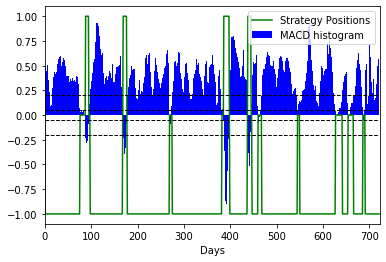

In [6]:
# Implement MACD trading strategy
X, y = prepare_dataset(close)

In [7]:
X[0]

array([ 0.23844323, -0.78286212, -1.02130535, 75.92496872, 17.09802862,
       79.99933624,  0.22760954, -1.6703993 , 76.43109612])

In [8]:
# Split dataset
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [9]:
# Normalize data
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Encode trading signal with integers between 0 and n-1 classes
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

[-1.  0.  1.]


In [11]:
## Create and train the Agent
# Variable definiton
episodes = 20
look_back = 5
batch_size = 32
action_size = len(le.classes_)
n_features = X_train.shape[1]

In [12]:
# Create Agent
agent = Agent(look_back, action_size, n_features)

In [13]:
def run(agent, dataX, dataY, episodes, look_back):
    """
    Function run to train the agent
    """
    
    # Length of dataset
    times = len(dataX)

    # List of total rewards
    total_reward_list = []

    for ep in range(episodes):

        # print('Episode: ' + str(ep))
        
        # Initial state and position
        state = dataX[:look_back, :][np.newaxis, :, :]
        pos = dataY[look_back - 1]

        done = False
        total_reward = 0

        for t in range(1, times - look_back + 1):

            # Predict action based on the current state
            action = agent.act(state)

            # Calculate reward
            if action == pos:   # 0:-1      1:0     2:1
                reward = +1

            elif (pos == 0 or pos == 2):
                if action == 1:
                    reward = 0
                else:
                    reward = -1
            else:
                reward = -1

            total_reward += reward

            # Final state
            if t == times - look_back:
                done = True

            # Receive next state and position
            next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
            next_pos = dataY[t + look_back - 1]
            
            # Remember current experience
            agent.remember(state, action, reward, next_state, done)
            
            # Make next_state the new current state; the same for pos
            state = next_state
            pos = next_pos

            if done:
                print('Episode: %i ---> Total Reward: %i' %(ep, total_reward))
                total_reward_list.append(total_reward)

            # Train the agent with previous experiences
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        if (ep + 1) % 5 == 0 and ep > 0:
            file = 'checkpoints/' + symbol + '_robot_checkpoint' + str(ep + 1)
            # Serialize weights to HDF5
            agent.model.save_weights(file + ".h5")
            # Save epsilon
            pickle.dump(agent.epsilon, open(file + "_epsilon.pickle", "wb"))

    # Save list of rewards along the epochs
    np.savetxt(file + '_total_reward.txt', total_reward_list)

    return


In [14]:
# Train Agent
run(agent, X_train, y_train, episodes, look_back)

Episode: 0 ---> Total Reward: 234
Episode: 1 ---> Total Reward: 375
Episode: 2 ---> Total Reward: 426
Episode: 3 ---> Total Reward: 420
Episode: 4 ---> Total Reward: 362
Episode: 5 ---> Total Reward: 416
Episode: 6 ---> Total Reward: 474
Episode: 7 ---> Total Reward: 476
Episode: 8 ---> Total Reward: 492
Episode: 9 ---> Total Reward: 510
Episode: 10 ---> Total Reward: 503
Episode: 11 ---> Total Reward: 507
Episode: 12 ---> Total Reward: 515
Episode: 13 ---> Total Reward: 499
Episode: 14 ---> Total Reward: 507
Episode: 15 ---> Total Reward: 528
Episode: 16 ---> Total Reward: 517
Episode: 17 ---> Total Reward: 515
Episode: 18 ---> Total Reward: 533
Episode: 19 ---> Total Reward: 527


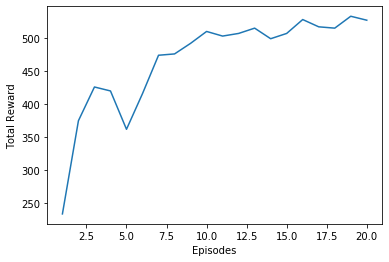

In [15]:
# Load rewards
total_reward_list = np.loadtxt( 'checkpoints/'+ symbol + '_robot_checkpoint' + str(episodes) + '_total_reward.txt')
# Plot
plt.figure()
plt.plot(np.arange(1, episodes+1), total_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

In [16]:
total_reward_list

array([234., 375., 426., 420., 362., 416., 474., 476., 492., 510., 503.,
       507., 515., 499., 507., 528., 517., 515., 533., 527.])

In [17]:
def evaluate(agent, dataX, dataY, look_back):
    """
    Function run to evaluate the trained agent
    """
    
    # Length of dataset
    times = len(dataX)

    # Initial state and position
    state = dataX[:look_back, :][np.newaxis, :, :]
    pos = dataY[look_back - 1]

    # List of predicted positions
    pos_list = []
    
    done = False
    total_reward = 0
    
    for t in range(1, times - look_back + 1):

        # Predict action based on the current state
        action = agent.act(state)

        # Calculate reward
        if action == pos:   # 0:-1      1:0     2:1
            reward = +1

        elif (pos == 0 or pos == 2):
            if action == 1:
                reward = 0
            else:
                reward = -1
        else:
            reward = -1

        pos_list.append(action)
        total_reward += reward

        # Final state
        if t == times - look_back:
            done = True

        # Receive next state and position
        next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
        next_pos = dataY[t + look_back - 1]

        # Remember current experience
        agent.remember(state, action, reward, next_state, done)

        # Make next_state the new current state; the same for pos
        state = next_state
        pos = next_pos

        if done:
            print('Total Reward: %i' % total_reward)

    return np.array(pos_list)

In [18]:
# Evaluate the model
# Make predictions
y_pred_test = evaluate(agent, X_test, y_test, look_back)

# Calculate and print accuracy
acc = accuracy_score(y_test[look_back-1:-1], y_pred_test)

print('Accuracy: %.2f %%' % (acc*100))

Total Reward: 105
Accuracy: 78.57 %


In [19]:
# Calculate and print precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test[look_back-1:-1], y_pred_test, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

print(results.round(decimals=3))

      1-Precision  2-Recall  3-F1 score  4-Support
-1.0        0.965     0.759       0.850        108
 0.0        0.528     0.875       0.659         32
 1.0        0.000     0.000       0.000          0


C:\Users\Elid-PC.DESKTOP-MG9DS93\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Decodificate labels
y_true_test = le.inverse_transform(y_test[look_back-1:-1])
y_pred_test = le.inverse_transform(y_pred_test)

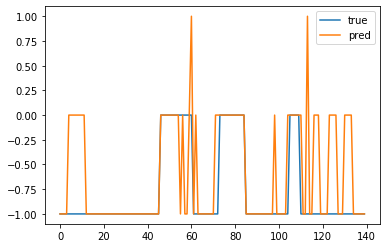

In [21]:
# Plot strategy
plt.figure()
plt.plot(y_true_test, label='true')
plt.plot(y_pred_test, label='pred')
plt.legend()
plt.show()